In [1]:
import torch
import random
import os
from torch import nn
from torch.utils.data import Dataset,DataLoader

corpus_file = 'hw2.1_corpus.txt'

In [2]:
# Load Corpus

corpus = []
with open(corpus_file,'r') as f:
    for row in f:
        row = row.replace('\n','')
        row = [w for w in row]
        corpus.append(row)

In [3]:
# Use list to guarantee the embedded index for each word are same everytime

words = []
words_set = set()
for ws in corpus:
    for w in ws:
        if w not in words_set:
            words_set.add(w)
            words.append(w)

In [4]:
import re

class Embedding:

    def __init__(self,words=None,dim=300):
        self.word_dict = {}
        self.word_list = []
        self.emb_dim = dim
        self.maxPOS = 55      # Maximum POS
        self.addition_words = ['<PAD>','<SOS>','<EOS>','<UNK>']
        
        for POS in range(self.maxPOS):
            self.addition_words.append(str(POS))
        
        for addition_word in self.addition_words:
            if addition_word not in words:
                self.word_dict[addition_word] = len(self.word_list)
                self.word_list.append(addition_word)
        
        for word in words:
            if word not in self.word_dict:
                self.word_dict[word] = len(self.word_list)
                self.word_list.append(word)
                
        self.vectors = torch.nn.init.uniform_(
                torch.empty(len(self.word_dict),dim))
        
    def to_index(self, word):
        # single word tokenize
        if word not in self.word_dict:
            return self.word_dict['<UNK>']
        
        return self.word_dict[word]
        
    def tokenize(self, words):
        # whole sentence tokenize
        return [self.to_index(w) for w in words]
    
    def to_word(self, idx):
        
        return self.word_list[idx]
        
    def unTokenize(self,ids):
        
        return [self.to_word(idx) for idx in ids]
        
    def get_vocabulary_size(self):
        return self.vectors.shape[0]
    
    def get_dim(self):
        return self.vectors.shape[1]

In [5]:
# establish embedder to tokenize
embedder = Embedding(words=words,dim=300)

PAD = embedder.to_index('<PAD>')
SOS = embedder.to_index('<SOS>')
EOS = embedder.to_index('<EOS>')

In [6]:
all_set = []
two_hint_ratio = 0.0

for former,latter in zip(corpus[:-1],corpus[1:]):
    
    n = len(latter)
    addition_tokens = []
    
    hint_word = 2 if random.random() < two_hint_ratio else 1

    selected_idice = random.sample(list(range(min(n,embedder.maxPOS))), k=min(n,hint_word))
    
    for selected_idx in selected_idice:
        
        addition_tokens.append(str(selected_idx+1))
        addition_tokens.append(latter[selected_idx])
    
    former = ['<SOS>'] + former + ['<EOS>'] + addition_tokens
    latter = ['<SOS>'] + latter + ['<EOS>']
    
    
    all_set.append((former,latter))

In [7]:
from sklearn.model_selection import train_test_split

train_set,valid_set = train_test_split(all_set,test_size=0.2,random_state=42)

print(len(all_set),len(train_set),len(valid_set))

741714 593371 148343


In [8]:
# list of turple : [(x0,y0),(x1,y1),(x2,y2),....]
all_set[5]

(['<SOS>',
  '你',
  '最',
  '想',
  '去',
  '的',
  '目',
  '的',
  '地',
  '剩',
  '多',
  '少',
  '公',
  '里',
  '<EOS>',
  '7',
  '我'],
 ['<SOS>', '累', '了', '也', '没', '关', '系', '我', '可', '以', '暂', '停', '<EOS>'])

In [9]:

class SentDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        
        return self.data[index]
        
    def collate_fn(self, datas):
        # get max length in this batch
        max_data_len = max([len(data[0]) for data in datas])
        max_label_len = max([len(data[1]) for data in datas])
        
        batch_x = []
        batch_y = []
        len_x = []
        len_y = []
        batch_y_ = []
        
        
        for data,label in datas:
            
            len_x.append(len(data))
            len_y.append(len(label))
            
            # Tokenize
            pad_data = embedder.tokenize(data)
            pad_label = embedder.tokenize(label)
            
            # Padding data and label
            if len(data) < max_data_len:
                pad_data.extend([PAD] * (max_data_len-len(data)))
            if len(label) < max_label_len:
                pad_label.extend([PAD] * (max_label_len-len(label)))
                
                
            batch_x.append(pad_data)
            batch_y.append(pad_label)
            
            # generate y_
            focus_designate = [PAD] * len(pad_label)
            focus_designate[0] = SOS
            focus_designate[pad_label.index(EOS)] = EOS
            
            for i in range(data.index('<EOS>')+1,len(data),2):
                
                idx = int(data[i])
                focus_designate[idx] = pad_label[idx]
            
            batch_y_.append(focus_designate)
            
            
        return torch.LongTensor(batch_x), torch.LongTensor(len_x), torch.LongTensor(batch_y), len_y, torch.LongTensor(batch_y_)

In [10]:
# For Validate~~~~

dataset = SentDataset(train_set)
dataloader = DataLoader(dataset=dataset,
                        batch_size=4,
                        shuffle=True,
                        collate_fn=dataset.collate_fn,
                        num_workers=0)
for x,x_len,y,y_len,y_ in dataloader:
    print('Sentence lenght:',x_len,y_len,'\n')
    
    for xi,yi,y_i in zip(x,y,y_):      
        
        print(embedder.unTokenize(xi))
        print(embedder.unTokenize(yi))
        print(embedder.unTokenize(y_i),'\n')
    
    break


Sentence lenght: tensor([ 8, 18, 10, 15]) [9, 17, 5, 11] 

['<SOS>', '别', '人', '都', '说', '<EOS>', '2', '们', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', '我', '们', '迟', '早', '会', '分', '开', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', '<PAD>', '们', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>'] 

['<SOS>', '根', '本', '融', '入', '不', '进', '一', '群', '人', '的', '狂', '欢', '狂', '欢', '<EOS>', '7', '沉']
['<SOS>', '别', '让', '我', '再', '昏', '昏', '沉', '沉', '没', '喝', '多', '就', '像', '断', '片', '<EOS>']
['<SOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '沉', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<EOS>'] 

['<SOS>', '就', '在', '这', '一', '分', '秒', '<EOS>', '1', '再', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', '再', '策', '动', '<EOS>', '<PAD>', '<PAD

In [11]:
from torch.nn.utils.rnn import  pack_padded_sequence, pad_packed_sequence

class Encoder(nn.Module):

    def __init__(self, vocab_size, embedding_size, output_size):
        
        super(Encoder, self).__init__()

        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size,embedder.get_dim())
        self.embedding.weight = nn.Parameter(embedder.vectors)
        self.gru = nn.GRU(embedding_size, output_size,batch_first=True, bias=False) 

    def forward(self, input_seqs, input_lengths, hidden=None):
        
        # Sort mini-batch by input_lengths
        sorted_input_lengths, indices = torch.sort(input_lengths,descending=True)
        _, desorted_indices = torch.sort(indices, descending=False)
        input_seqs = input_seqs[indices]
        
        # Encoder work
        embedded = self.embedding(input_seqs)
        packed = pack_padded_sequence(embedded, sorted_input_lengths.cpu().numpy(), batch_first=True)
        packed_outputs, hidden = self.gru(packed, hidden)
        outputs, output_lengths = pad_packed_sequence(packed_outputs,batch_first=True)
        
        # Desort mini-batch
        outputs = outputs[desorted_indices]
        hidden = hidden[:,desorted_indices]
        
        return outputs, hidden

In [12]:
class Decoder(nn.Module):

    def __init__(self, hidden_size, output_size, teacher_forcing_ratio=0.5):
        super(Decoder, self).__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding = nn.Embedding(embedder.get_vocabulary_size(),embedder.get_dim()) # Unused
        self.embedding.weight = nn.Parameter(embedder.vectors)
        self.cell = nn.GRUCell(embedder.get_dim(), hidden_size, bias=False)
        self.clf = nn.Linear(hidden_size, output_size, bias=False)
        
        if hidden_size == embedder.vectors.T.shape[0]:
            self.clf.weight = nn.Parameter(embedder.vectors)

        self.log_softmax = nn.LogSoftmax(dim=1)  # work with NLLLoss

        self.teacher_forcing_ratio = teacher_forcing_ratio

    def forward_step(self, inputs, hidden):
        
        # Unused
        embedded = self.embedding(inputs)
        # For research : all x to 0
        embedded = torch.zeros_like(embedded)
        
        hidden = self.cell(embedded, hidden) # [B,Hidden_dim]
        clf_output = self.clf(hidden) # [B,Output_dim]
        output = self.log_softmax(clf_output)

        return output, hidden

    def forward(self, context_vector, target_vars, target_lengths):

        batch_size = context_vector.shape[1]
        
        decoder_input = torch.LongTensor([SOS] * batch_size).to(device)
        decoder_hidden = context_vector.squeeze(0)

        if target_lengths is None:
            max_target_length = 50
        else:
            max_target_length = max(target_lengths)
        decoder_outputs = []
        decoder_hiddens = []

        use_teacher_forcing = True if random.random() < self.teacher_forcing_ratio else False
        
        for t in range(max_target_length):    
            
            decoder_outputs_on_t, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_outputs_on_t)
            decoder_hiddens.append(decoder_hidden)
            
            # Take input for next GRU iteration
            if use_teacher_forcing :
                decoder_input = target_vars[:,t]
            else:
                decoder_input = decoder_outputs_on_t.argmax(-1)
            
            # Early Stop when all predict <EOS> 
            if torch.all(decoder_input==EOS) and target_lengths is None and self.train() == False:
                break
            
        # Stack output of each word at dimension 2
        decoder_outputs = torch.stack(decoder_outputs,dim=2)
        # Stack hidden of each timestep at dimension 1
        decoder_hiddens = torch.stack(decoder_hiddens,dim=1)
        
        return decoder_outputs, decoder_hiddens

In [13]:
class Seq2Seq(nn.Module):
    def __init__(self,encoder,decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, input_seqs, input_lengths, target_seqs=None, target_lengths=None):
        outputs, hidden = encoder(input_seqs, input_lengths)
        outputs, hiddens = decoder(hidden, target_seqs, target_lengths)
        return outputs,hiddens

In [14]:
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook as tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

context_dim = 128

encoder = Encoder(embedder.get_vocabulary_size(),embedder.get_dim(),output_size=context_dim)
decoder = Decoder(context_dim,embedder.get_vocabulary_size(),0.5)
model = Seq2Seq(encoder,decoder)
model.to(device)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(6618, 300)
    (gru): GRU(300, 128, bias=False, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(6618, 300)
    (cell): GRUCell(300, 128, bias=False)
    (clf): Linear(in_features=128, out_features=6618, bias=False)
    (log_softmax): LogSoftmax()
  )
)

# Training ( Dont run when analysing )

In [15]:
'''
def run_epoch(epoch,dataset,isTraining):
    
    if isTraining:
        model.train()
    else:
        model.eval()
        
    dataloader = DataLoader(dataset=dataset,
                            batch_size=32,
                            shuffle=True,
                            collate_fn=dataset.collate_fn,
                            num_workers=0)
    
    if isTraining:
        desc='Train {}'
    else:
        desc='Valid {}'
    
    trange = tqdm(enumerate(dataloader), total=len(dataloader),desc=desc.format(epoch))
    
    loss=0
    acc = 0
    
    for i,(x,x_len,y,y_len,y_) in trange:
        
        x = x.to(device)
        y = y.to(device)
        y_ = y_.to(device)
        
        # outputs : [b,emb,s] , hiddens : [b,s,hidden]
        outputs,hiddens = model(x,x_len,y,y_len)
        
        idx = y_>2
        tf_map = y_[idx] == outputs.argmax(1)[idx]
        batch_acc = tf_map.sum().cpu().float().numpy()/len(tf_map)
        acc += batch_acc
        
        batch_loss_all = criterion(outputs, y)
        batch_loss_designated = criterion(outputs, y_)
        batch_loss = (1-focus_ratio)*batch_loss_all + focus_ratio*batch_loss_designated
        
        if isTraining:
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
        
        loss += batch_loss.item()
        
        trange.set_postfix({'loss':loss/(i+1),'accuracy':acc/(i+1)})
        
        if isTraining:
            history_loss['train'].append(batch_loss.item())
            history_acc['train'].append(batch_acc)
        else:
            history_loss['valid'].append(batch_loss.item())
            history_acc['valid'].append(batch_acc)
            '''

"\ndef run_epoch(epoch,dataset,isTraining):\n    \n    if isTraining:\n        model.train()\n    else:\n        model.eval()\n        \n    dataloader = DataLoader(dataset=dataset,\n                            batch_size=32,\n                            shuffle=True,\n                            collate_fn=dataset.collate_fn,\n                            num_workers=0)\n    \n    if isTraining:\n        desc='Train {}'\n    else:\n        desc='Valid {}'\n    \n    trange = tqdm(enumerate(dataloader), total=len(dataloader),desc=desc.format(epoch))\n    \n    loss=0\n    acc = 0\n    \n    for i,(x,x_len,y,y_len,y_) in trange:\n        \n        x = x.to(device)\n        y = y.to(device)\n        y_ = y_.to(device)\n        \n        # outputs : [b,emb,s] , hiddens : [b,s,hidden]\n        outputs,hiddens = model(x,x_len,y,y_len)\n        \n        idx = y_>2\n        tf_map = y_[idx] == outputs.argmax(1)[idx]\n        batch_acc = tf_map.sum().cpu().float().numpy()/len(tf_map)\n        

In [16]:
# Training

'''


dataset_all = SentDataset(all_set)
dataset_train = SentDataset(train_set)
dataset_valid = SentDataset(valid_set)

criterion = torch.nn.NLLLoss(ignore_index=PAD, size_average=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
max_epoch = 20
focus_ratio = 0.5

history_loss = {'train':[],'valid':[]}
history_acc = {'train':[],'valid':[]}


for epoch in range(max_epoch):
    
    # Training
    run_epoch(epoch,dataset=dataset_train,isTraining=True)
    
    # Validation
    run_epoch(epoch,dataset=dataset_valid,isTraining=False)
    
    # Saving
    if not os.path.exists('model'):
        os.makedirs('model')
    torch.save(model.state_dict(), 'model/model.pkl.{}'.format(epoch))
    '''

"\n\n\ndataset_all = SentDataset(all_set)\ndataset_train = SentDataset(train_set)\ndataset_valid = SentDataset(valid_set)\n\ncriterion = torch.nn.NLLLoss(ignore_index=PAD, size_average=True)\noptimizer = torch.optim.Adam(model.parameters(), lr=1e-3)\nmax_epoch = 20\nfocus_ratio = 0.5\n\nhistory_loss = {'train':[],'valid':[]}\nhistory_acc = {'train':[],'valid':[]}\n\n\nfor epoch in range(max_epoch):\n    \n    # Training\n    run_epoch(epoch,dataset=dataset_train,isTraining=True)\n    \n    # Validation\n    run_epoch(epoch,dataset=dataset_valid,isTraining=False)\n    \n    # Saving\n    if not os.path.exists('model'):\n        os.makedirs('model')\n    torch.save(model.state_dict(), 'model/model.pkl.{}'.format(epoch))\n    "

# Plot (Loss and acc)  ( Dont run when analysis )

In [17]:
'''
import matplotlib.pyplot as plt

modes = ['train', 'valid']
recs = [history_loss, history_acc]
names = ['Loss', 'Accuracy']

values = []
for mode in modes:
    v = []
    for rec in recs:
        v.append(rec[mode])
    values.append(v)

plt.figure(figsize=(32, 4))
plt.subplots_adjust(left=0.02, right=0.999)
for r, name in enumerate(names):
    plt.subplot(1, len(recs), r+1)
    for m in range(len(modes)):
        plt.plot(values[m][r])
    plt.title(name)
    plt.legend(modes)
    plt.xlabel('iteration')
    plt.show()
#plt.savefig('figure.png', dpi=100)
'''

"\nimport matplotlib.pyplot as plt\n\nmodes = ['train', 'valid']\nrecs = [history_loss, history_acc]\nnames = ['Loss', 'Accuracy']\n\nvalues = []\nfor mode in modes:\n    v = []\n    for rec in recs:\n        v.append(rec[mode])\n    values.append(v)\n\nplt.figure(figsize=(32, 4))\nplt.subplots_adjust(left=0.02, right=0.999)\nfor r, name in enumerate(names):\n    plt.subplot(1, len(recs), r+1)\n    for m in range(len(modes)):\n        plt.plot(values[m][r])\n    plt.title(name)\n    plt.legend(modes)\n    plt.xlabel('iteration')\n    plt.show()\n#plt.savefig('figure.png', dpi=100)\n"

# Inference Test Data
### Define test data dataloader

In [18]:
class TestDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]
        
    def collate_fn(self, datas):
        max_data_len = max([len(data) for data in datas])
        batch_x = []
        len_x = []
        
        for data in datas:
            len_x.append(len(data))
            pad_data = [embedder.to_index(w) for w in data]
            if len(data) < max_data_len:
                pad_data.extend([PAD] * (max_data_len-len(data)))
            batch_x.append(pad_data)

        return torch.LongTensor(batch_x), torch.LongTensor(len_x)

## Load pre-trained model

In [19]:
path_pkl = 'pre-train/model.pkl.2-1-1'
model.load_state_dict(torch.load(path_pkl))
model.decoder.teacher_forcing_ratio = 0.0
model.eval()

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(6618, 300)
    (gru): GRU(300, 128, bias=False, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(6618, 300)
    (cell): GRUCell(300, 128, bias=False)
    (clf): Linear(in_features=128, out_features=6618, bias=False)
    (log_softmax): LogSoftmax()
  )
)

## Generate certain condition valid datas ( by designated word / position filter )

In [20]:
certain_set = []

designated_POS = 6
designated_word = '勇'

for i,sent in enumerate(random.sample(corpus, k=100)):

    if len(sent) > 8:
        sent = sent[:8]
    else:
        sent = sent + ['啊']*(8-len(sent))
        
    designated_POS = random.randint(a=1,b=10)
    
    control_signal = [str(designated_POS) , designated_word]
    
    data = ['<SOS>'] + sent + ['<EOS>'] + control_signal
    
    print(data)
    
    certain_set.append(data)
    
dataset_certain = TestDataset(certain_set)

['<SOS>', '酒', '干', '倘', '卖', '无', '酒', '干', '倘', '<EOS>', '3', '勇']
['<SOS>', '算', '了', '吧', '都', '已', '经', '到', '此', '<EOS>', '5', '勇']
['<SOS>', '啦', '啦', '啦', '啦', '啦', '啦', '耶', '拉', '<EOS>', '5', '勇']
['<SOS>', '温', '柔', '的', '狗', '狗', '啊', '啊', '啊', '<EOS>', '10', '勇']
['<SOS>', '就', '像', '你', '不', '知', '道', '这', '竟', '<EOS>', '4', '勇']
['<SOS>', '编', '曲', '薛', '琳', '可', '啊', '啊', '啊', '<EOS>', '2', '勇']
['<SOS>', '还', '是', '我', '自', '己', '想', '得', '太', '<EOS>', '4', '勇']
['<SOS>', '纵', '情', '在', '一', '霎', '那', '啊', '啊', '<EOS>', '5', '勇']
['<SOS>', '反', '正', '爱', '只', '能', '那', '么', '浓', '<EOS>', '9', '勇']
['<SOS>', '编', '曲', '小', '皮', '啊', '啊', '啊', '啊', '<EOS>', '8', '勇']
['<SOS>', '为', '爱', '情', '在', '努', '力', '啊', '啊', '<EOS>', '3', '勇']
['<SOS>', '注', '定', '要', '接', '受', '一', '个', '人', '<EOS>', '4', '勇']
['<SOS>', '就', '这', '种', '感', '觉', '真', '的', '不', '<EOS>', '10', '勇']
['<SOS>', '想', '你', '想', '你', '想', '你', '想', '你', '<EOS>', '5', '勇']
['<SOS>', '虽', '然', '漏', '着', '雨

# Control

In [21]:
pos_control_cell = [59,90,91,33,110,117,71,82,24,36,21,39,73,119,97,98]

In [22]:
global context_spos_set

context_spos_set = [None] * 11

for spos in range(1,11):

    context_spos = ['<SOS>', '让', '我', '拥', '有', '了', '恬', '静', '的', '<EOS>', str(spos), '静']
    len_context = torch.LongTensor([len(context_spos)])
    context_spos = [embedder.to_index(w) for w in context_spos]
    context_spos = torch.LongTensor([context_spos]).to(device)
    context_spos = model.encoder(context_spos,len_context)[1].squeeze()
    
    context_spos_set[spos] = context_spos

In [23]:
import torch.nn.functional as F

def Deconstruction(model,x,x_len,special_cells=[],spos=5):
    
    # Encoder 
    encoder_hiddens, context = model.encoder(x,x_len)
    
    
    for c in special_cells:
        context[0,:,c] = context_spos_set[spos][c]
        encoder_hiddens[:,-1,c] = context_spos_set[spos][c]
    
    # Decoder
    decoder_hidden = context.squeeze(0)
    
    # Collection signal
    decoder_outputs = []
    decoder_hiddens = []
    decoder_resetGates = []
    decoder_updateGates = []
    decoder_newGates = []
    
    while True:
        
        # GRU Cell
        gru = model.decoder.cell
        
        U_h = F.linear(decoder_hidden, gru.weight_hh)
        Ur_h, Uz_h, Un_h = U_h.chunk(3, 1)
        reset_gate = torch.sigmoid(Ur_h)
        update_gate = torch.sigmoid(Uz_h)
        new_gate = torch.tanh(reset_gate * Un_h)
        decoder_hidden = new_gate + update_gate * (decoder_hidden - new_gate)
        
        # Classifier
        clf_output = model.decoder.clf(decoder_hidden)
        decoder_output = model.decoder.log_softmax(clf_output)
        
        decoder_resetGates.append(reset_gate)
        decoder_updateGates.append(update_gate)
        decoder_newGates.append(new_gate)
        decoder_outputs.append(decoder_output)            
        decoder_hiddens.append(decoder_hidden)
                                                   
        if torch.all(decoder_output.argmax(-1)==EOS) == True:
            break
            
    outputs = torch.stack(decoder_outputs,dim=2)             # (b,6xxx,s)
    
    gru_info = {
        'hiddens':torch.stack(decoder_hiddens,dim=2),             # (b,128,s)
        'resetgates':torch.stack(decoder_resetGates,dim=2),       # (b,128,s)
        'updategates':torch.stack(decoder_updateGates,dim=2),     # (b,128,s)
        'newgates':torch.stack(decoder_newGates,dim=2),           # (b,128,s)
        'encoder_hiddens' : encoder_hiddens.permute(0,2,1),       # (b,128,s)
        'context' : context.squeeze(0)                            # (b,128)
    }
    
    return outputs, gru_info

## Prediction certain condition data

In [31]:
dataloader = DataLoader(dataset=dataset_certain,
                        batch_size=512,
                        shuffle=False,
                        collate_fn=dataset_certain.collate_fn,
                        num_workers=0)

predictions = []
trange = tqdm(enumerate(dataloader), total=len(dataloader))

for i,(x,x_len) in trange:
    
    x = x.to(device)
    
    outputs,gru_info = Deconstruction(model,x,x_len)
    
    for pred in outputs.cpu().detach().numpy().argmax(1):
        predictions.append(pred)

In [32]:
# Process multi-EOS tokens
predictions_set = []
for p in predictions:
    p = list(p)
    if EOS in p:
        p = p[:p.index(EOS)+1]
    else:
        p.append(EOS)
    predictions_set.append(embedder.unTokenize(p))
    

for sent_id in range(len(certain_set)):
    sent_in = ''.join(certain_set[sent_id])
    sent_pred = ''.join(predictions_set[sent_id])
    print('{}\ninput:\t{}\npred:\t{}\n'.format((sent_id%10)+1,sent_in,sent_pred))

1
input:	<SOS>酒干倘卖无酒干倘<EOS>3勇
pred:	<SOS>我要勇敢<EOS>

2
input:	<SOS>算了吧都已经到此<EOS>5勇
pred:	<SOS>我不不我勇敢<EOS>

3
input:	<SOS>啦啦啦啦啦啦耶拉<EOS>5勇
pred:	<SOS>我我我我勇敢<EOS>

4
input:	<SOS>温柔的狗狗啊啊啊<EOS>10勇
pred:	<SOS>我不的的的的的的的勇<EOS>

5
input:	<SOS>就像你不知道这竟<EOS>4勇
pred:	<SOS>我不我勇敢<EOS>

6
input:	<SOS>编曲薛琳可啊啊啊<EOS>2勇
pred:	<SOS>我勇敢<EOS>

7
input:	<SOS>还是我自己想得太<EOS>4勇
pred:	<SOS>我不我勇敢<EOS>

8
input:	<SOS>纵情在一霎那啊啊<EOS>5勇
pred:	<SOS>我不的的勇敢<EOS>

9
input:	<SOS>反正爱只能那么浓<EOS>9勇
pred:	<SOS>我不我不不不的的勇<EOS>

10
input:	<SOS>编曲小皮啊啊啊啊<EOS>8勇
pred:	<SOS>我是的的的的的勇<EOS>

1
input:	<SOS>为爱情在努力啊啊<EOS>3勇
pred:	<SOS>我有勇敢<EOS>

2
input:	<SOS>注定要接受一个人<EOS>4勇
pred:	<SOS>我不有勇敢<EOS>

3
input:	<SOS>就这种感觉真的不<EOS>10勇
pred:	<SOS>我不的的的不不的的勇<EOS>

4
input:	<SOS>想你想你想你想你<EOS>5勇
pred:	<SOS>我不你的勇敢<EOS>

5
input:	<SOS>虽然漏着雨啊啊啊<EOS>6勇
pred:	<SOS>我不的的的勇<EOS>

6
input:	<SOS>弹著你的晚安曲啊<EOS>4勇
pred:	<SOS>我不的勇敢<EOS>

7
input:	<SOS>我才不上你的当啊<EOS>6勇
pred:	<SOS>我不的的的勇<EOS>

8
input:	<SOS>我要全心灌溉所有<EOS>1勇
pred:	<SOS>勇敢<EOS>

9
input:	<SOS>鸟儿啊天黑了啊啊<EOS>

In [33]:
import matplotlib.pyplot as plt
import numpy as np

updategates = gru_info['updategates'].mean(0).detach().cpu().numpy()

resetgates = gru_info['resetgates'].mean(0).detach().cpu().numpy()

newgates = gru_info['newgates'].mean(0).detach().cpu().numpy()

hiddens = gru_info['hiddens'].mean(0).detach().cpu().numpy()

encoder_hiddens = gru_info['encoder_hiddens'].detach().cpu().numpy()

context = gru_info['context'].detach().cpu().numpy()

output_len = updategates.shape[1]

updategates.shape , resetgates.shape , newgates.shape , hiddens.shape, encoder_hiddens.shape,context.shape


((128, 12), (128, 12), (128, 12), (128, 12), (100, 128, 12), (100, 128))

In [34]:
encoder_hiddens_set = [[],[],[],[],[],[],[],[],[],[],[],[],[]]

for xi,hi in zip(x,encoder_hiddens):
    xi = xi.cpu().numpy()
    idx = np.where(xi==embedder.to_index('<EOS>'))[0][0]+1
    pos_id = xi[idx]
    pos = int(embedder.to_word(pos_id))
    encoder_hiddens_set[pos].append(hi)
    
for i in range(1,len(encoder_hiddens_set)):
    try:
        encoder_hiddens_set[i] = np.stack(encoder_hiddens_set[i],axis=0)
    except:
        print('pos',i,'is empty')
        pass

pos 11 is empty
pos 12 is empty


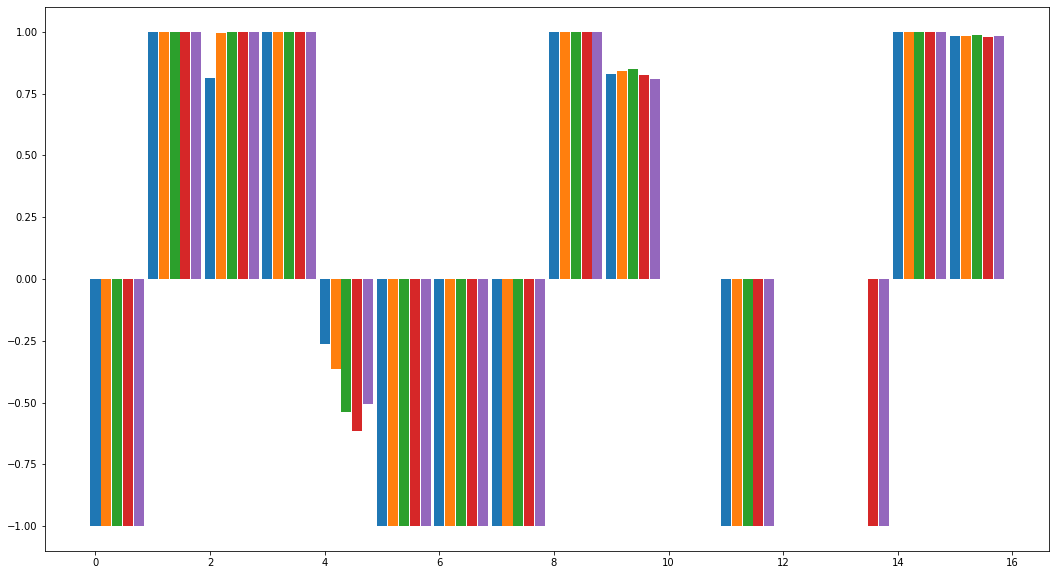

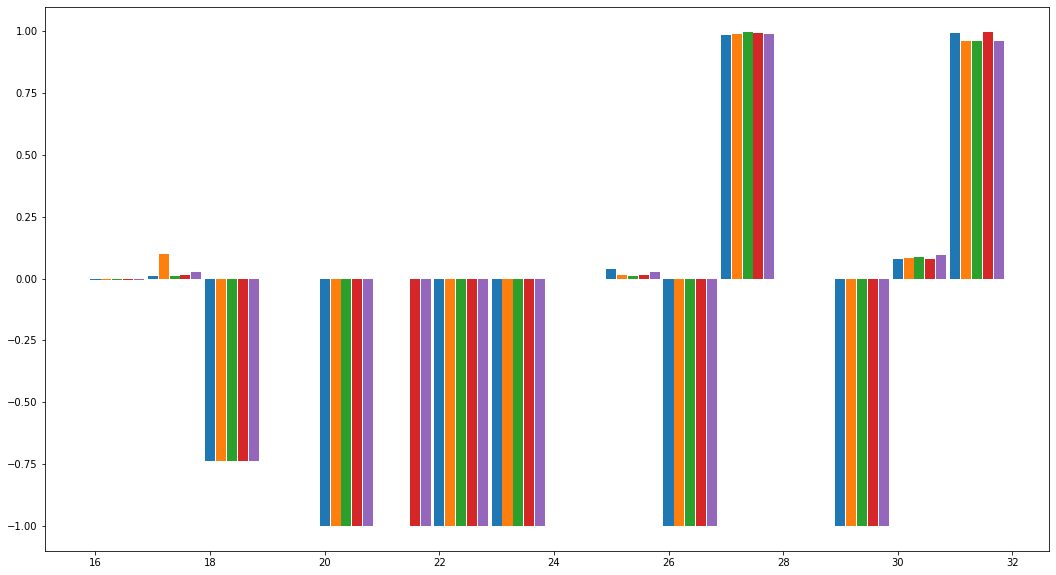

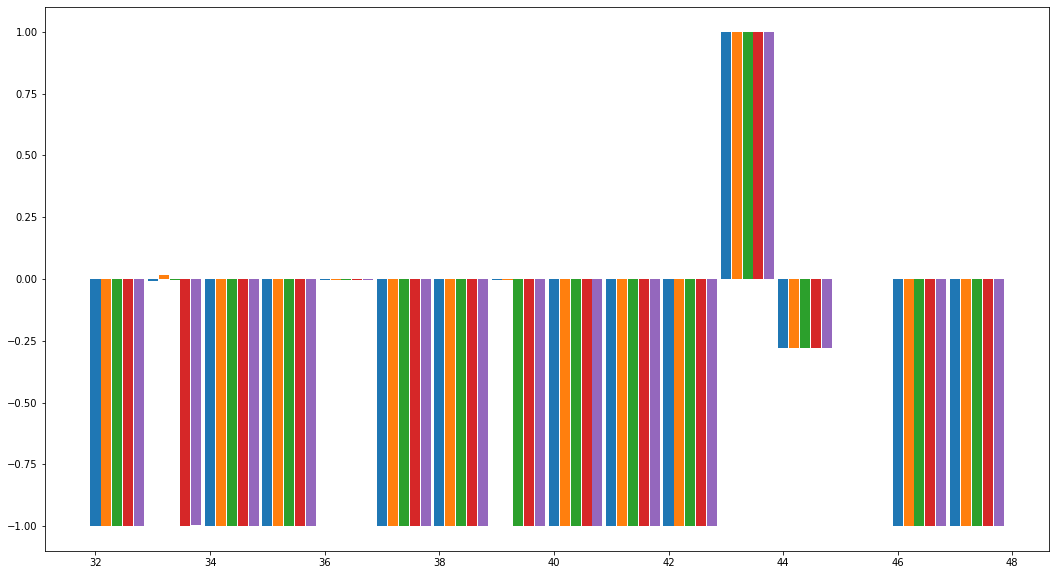

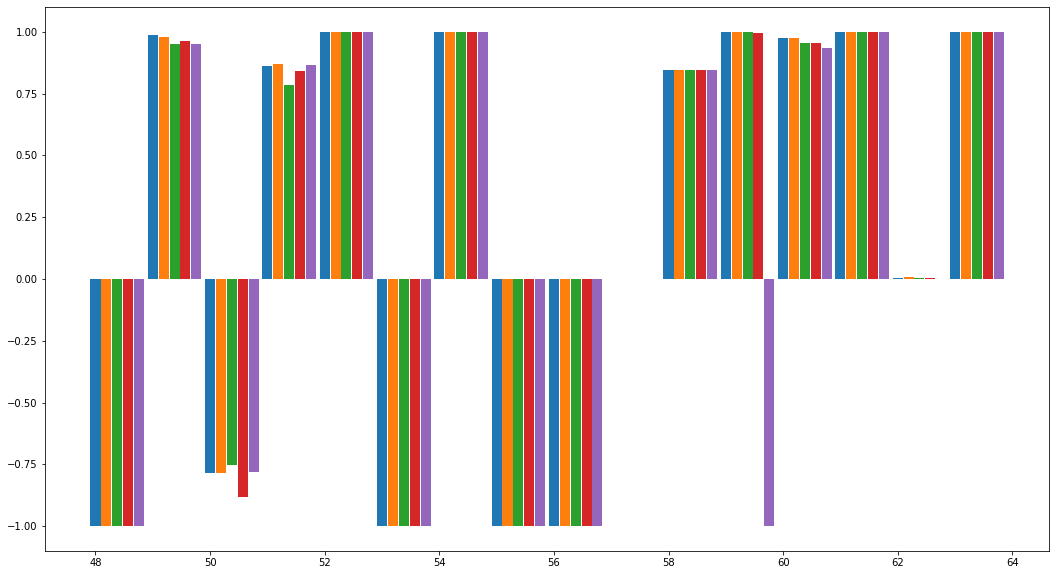

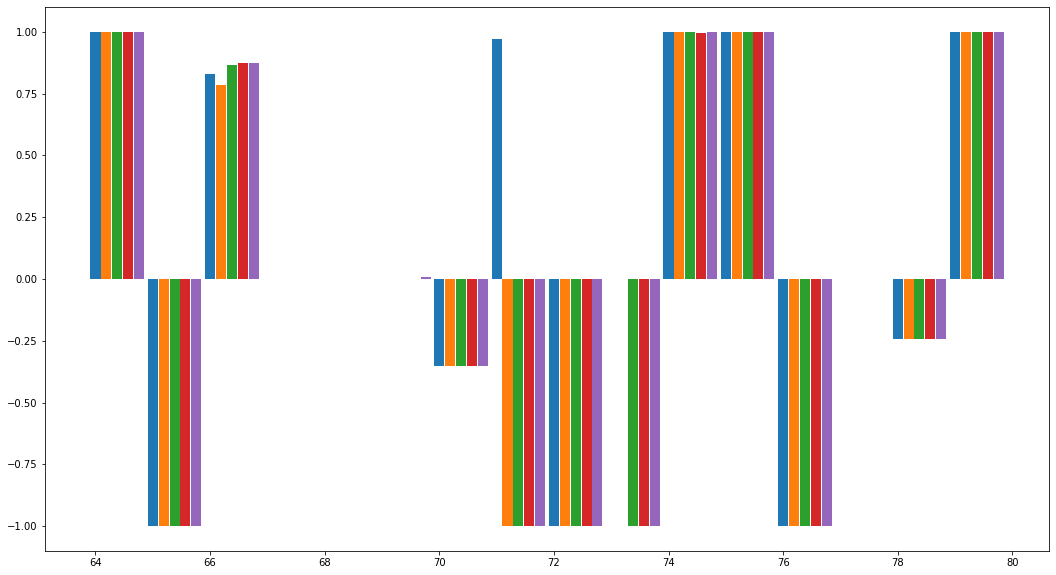

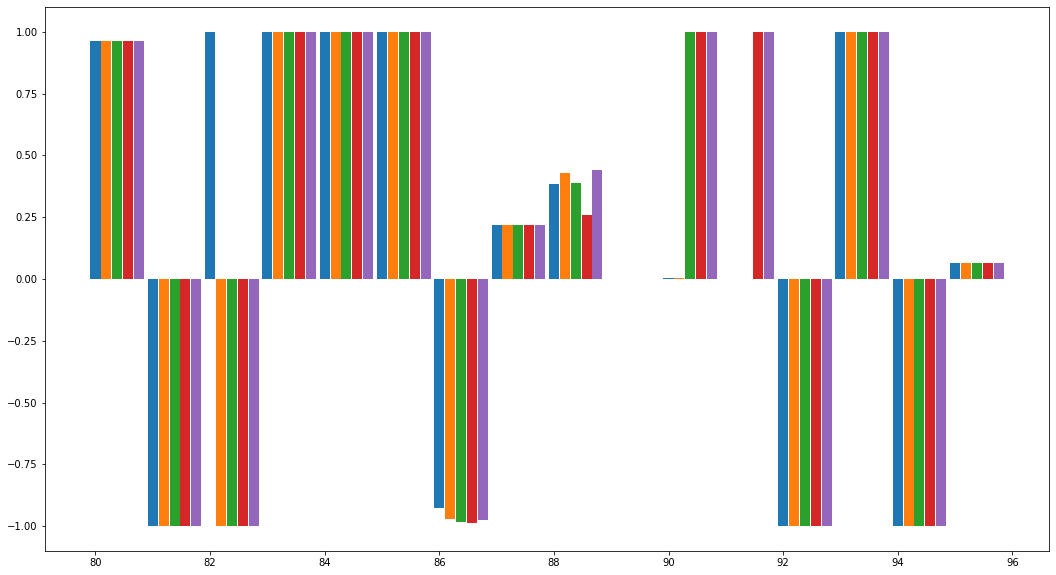

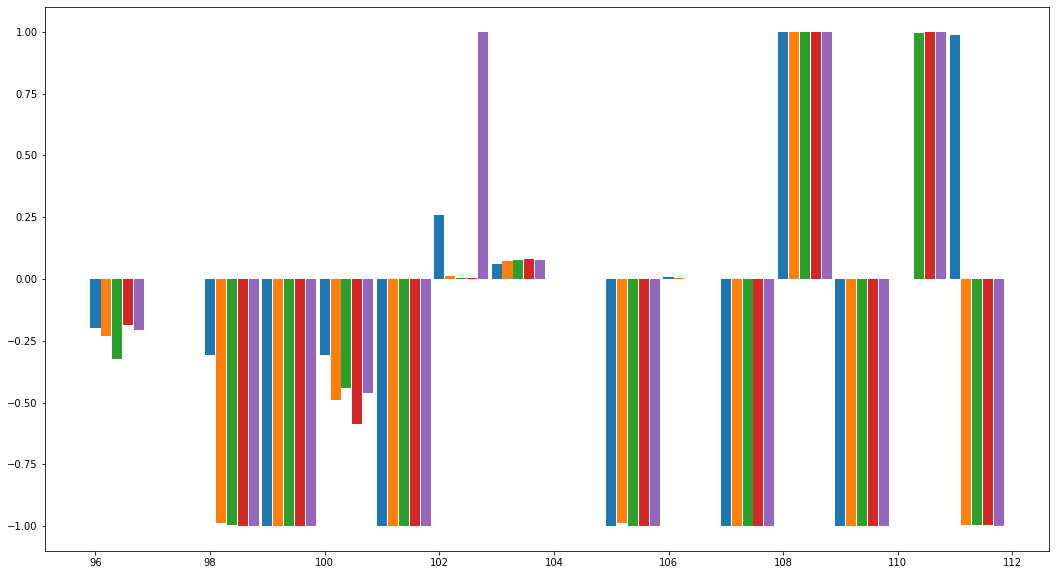

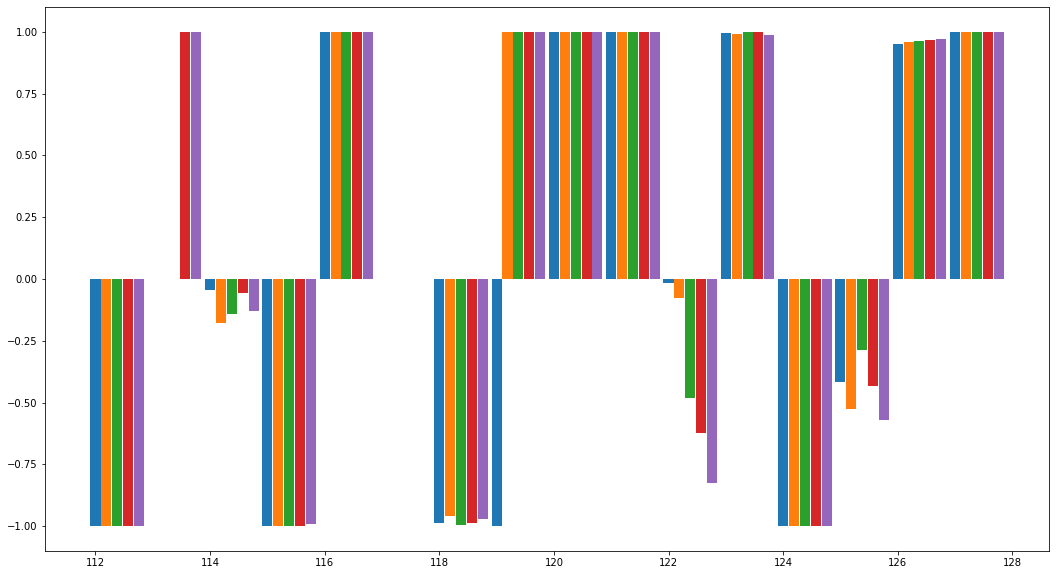

In [35]:

plt.close('all') 

frm = 0
to = 16

for _ in range(8):
    plt.subplots(1)
    
    a = np.arange(frm,to,1)
    
    for eh in encoder_hiddens_set[1:6]:

        plt.bar(a, eh.mean(0)[frm:to,-1],width=0.175)

        fig = plt.gcf()
        fig.set_size_inches(18,10)
        a = a + 0.19
        
    frm += 16
    to  += 16

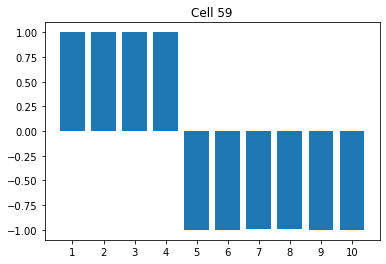

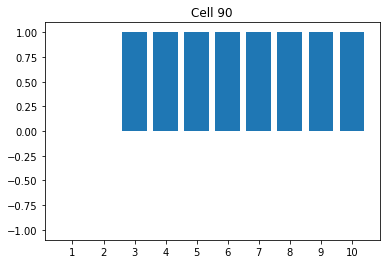

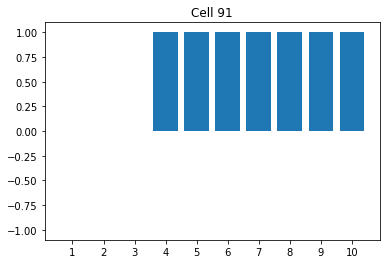

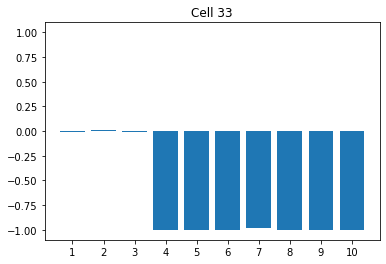

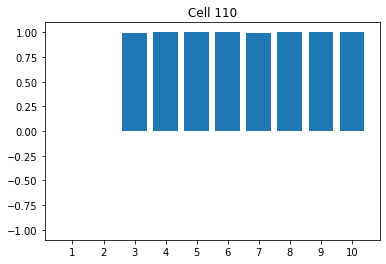

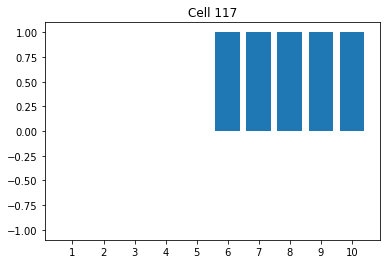

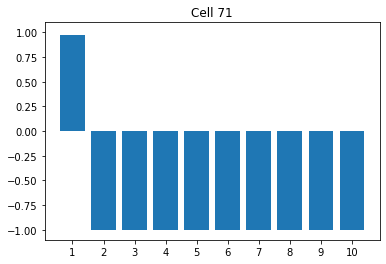

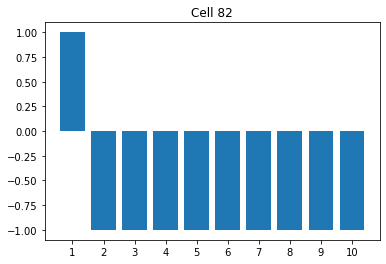

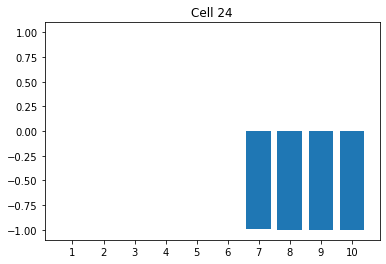

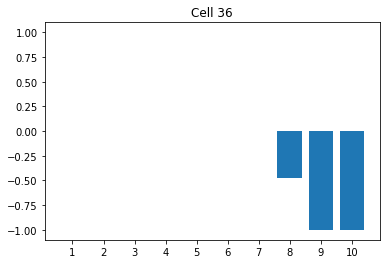

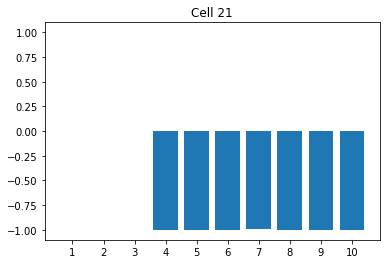

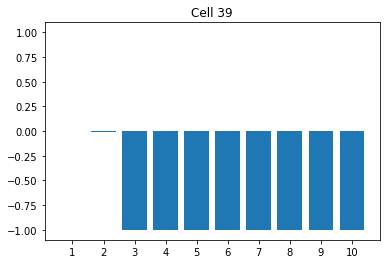

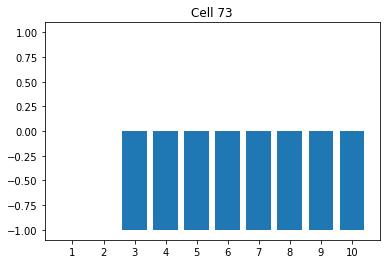

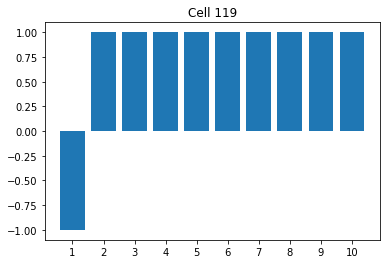

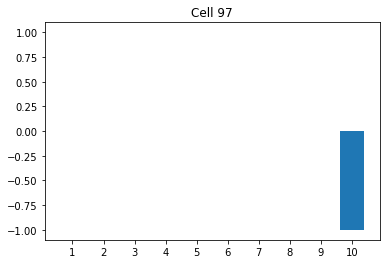

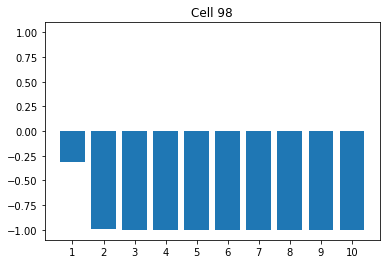

In [36]:
countCell = pos_control_cell
pos_hidden = np.arange(1,11)
for cell in countCell:
    plt.subplots(1)
    plt.title('Cell {}'.format(cell))
    plt.bar(pos_hidden,[ eh.mean(0)[cell,-1] for eh in encoder_hiddens_set[1:11]])
    plt.ylim((-1.1, 1.1))
    plt.xticks(np.linspace(1, 10, 10))